# Policy gradient methods: From REINFORCE to Actor Critic

The methods we learned in previous notebooks such as Monte Carlo Methods, TD-learning, and Deep Q-learning learn value functions and use them to learn optimal policy. There exists another category of methods that directly optimize the policy, rather than relying on the estimation of a value function. These methods are known as Policy Gradient Methods.

Policy Gradient Methods are especially useful, for example, when the policy is a more straightforward function to approximate compared to the value function. In such case, a policy-based method will typically learn faster and yield a superior asymptotic policy. In the opposite case where a value function may be simpler, estimating the value function might work better. Another important advantage of using policy gradient methods is that we can impose our prior on policy explicitly to construct the desired form of the policy.

In this notebook, we will learn three basic policy gradient methods, REINFORCE, REINFORCE with baseline, and Actor Critic. 
If we can understand the concept of REINFORCE, we would be able to understand the other two just by adding a few improvements to it. 
We first go over some theoretical concepts to develop an understanding on policy gradient methods and explore the fundamentals of REINFORCE.


---

In [4]:
# Import packages


import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # INFO and WARNING messages are not printed

import gym
import numpy as np
import matplotlib.pyplot as plt

%pip install tqdm
import tqdm

%pip install torch
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

%pip install ipython
from IPython.display import clear_output
from IPython import display

%matplotlib inline

# set random seeds
torch.manual_seed(0)
np.random.seed(0)

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Note: you may need to restart the kernel to use updated packages.
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 3.4 MB/s eta 0:00:0000:0100:01
Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
Using cached Jinja2-3.1.3-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.8 MB/s eta 0:00:0000:0100:01
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tqdm

In [ ]:
pip install tqdm

## Prepare environment

In this notebook, we utilize the CartPole-v0 environment in Gymnasium.

[Learn more about the CartPole-v0 environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

The goal of this environment is to balance a pole by applying forces in the left and right directions on the cart. It has a discrete action space:
- 0: Push cart to the left
- 1: Push cart to the right

Upon taking an action, either left or right, an agent observes a 4-dimensional state consisting of:
- Cart Position
- Cart Velocity
- Pole Angle
- Pole Angular Velocity

A reward of +1 is granted to the agent at each step while the pole is kept upright. The maximum reward an agent can earn in a single episode is 200.

The episode ends under the following conditions:
- Termination: Pole Angle is greater than ±12°
- Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- Truncation: Episode length exceeds 200 steps

In the code below, I provide an example of the agent randomly exploring this environment over 20 time steps.


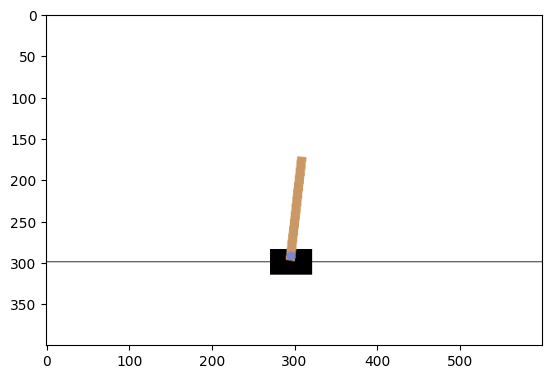

In [11]:
# Create CartPole environment
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, _ = env.reset()

# Run the environment for 20 steps
for i in range(20):
    # Display the current state of the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # Choose a random action from the action space
    action = env.action_space.sample()
    
    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, info = env.step(action)
    
    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()

# Close the environment after exploration
env.close()


## Policy Gradient Methods Theory

Policy Gradient Methods directly learn a parameterized policy that can select actions without estimating a value function. In mathematical expression, this means to learn the policy's parameter vector $\theta$ in the below expression

$$\pi(a|s,\theta)=P\{A_t=a|S_t=s, \theta_t=\theta\}$$

Here, $\pi(a|s,\theta)$ represents the probability of taking action $a$ at time $t$ given that the environment is in state $s$ at that time, with parameter $\theta$. Since our ultimate objective is to learn the optimal policy, it makes sense to directly optimize and learn it. But how do we achieve this?

A common approach is to define a model, such as a neural network, as a policy estimator. This model outputs an action probability distribution given a state. But what would be the objective function to optimize the parameter vector $\theta$?

For example, with Deep Q-learning (which is one of the value function estimation methods), we use Temporal Difference (TD) error to update the value function

$$ (R_{t+1} + \gamma \max_a Q_{\theta}(S_{t+1}, a)) - Q_{\theta^-}(S_t, A_t) $$

where $\theta$ is the parameters of the value function estimate and $\theta^-$ is the parameters of the target network, which are less frequently updated. By running backpropagation with this objective function, we can optimize the model estimating a value function. For more details, you can refer to [this notebook](https://www.kaggle.com/code/minaiyuki/deep-q-learning-dqn-tutorial-with-cartpole-v0).

For policy gradient methods, we can consider that the objective is a discounted return we can gain through adopting the policy. We run an optimization process to maximize this objective function.

Can we compute the gradient of this return? No, we don't exactly know the form of a return or reward function so we cannot directly compute the gradient. But **Policy Gradient Theorem** offers a way to compute the gradient of this function. 


### Policy Gradient Theorem

The Policy Gradient Theorem provides an analytic expression for the gradient of an objective (such as return) with respect to the policy parameter. Let's denote the objective function we would like to maximize as $J(\theta)$.
Then, the policy gradient theorem provides the estimate of the derivative of this function as follows:

$$ \nabla J(\theta) \propto \sum_s \mu(s) \sum_a q_{\pi}(s,a) \nabla \pi(a|s, \theta) $$

where $\nabla J(\theta)$ represents the gradient with respect to $\theta$, $\pi$ denotes the policy corersponding to parameter vector $\theta$, and $q_{\pi}(s,a)$ denotes the value of a state action pair under policy $\pi$. $\mu$ is the distribution of state $s$ under $\pi$. 
The detailed proof is offered in p.325 of Ref or this [link](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/).

Let's think about what this expression means. 
Remember that our goal is to maximize the objective function $J(\theta)$. So we would like to perform gradient ascent with respect to $\theta$. 
When a value of action $a$ under state $s$ is large (i.e. when $q_{\pi}(s,a)$ is a large value), we would like to make this action more likely because we can gain a large return. To achieve this, we multiply the derivative term $\nabla \pi(a|s, \theta)$ with this large estimated value of this state to move largely toward this gradient ascent direction. This causes this action to happen more likely.
On the other hand, when the value of action $a$ under $s$ is a small value (or even a negative value), we move the gradient ascent direction with a smaller step (or move away from this direction) and don't increase the probability of taking this action much (or reduce the probability of taking this action).

The first term $\sum_s \mu(s)$ controls the weight of each state. States that are more often visited have larger weights on the update of $\theta$ compared to the states that are rarely visited.

By iterating this update of $\theta$, the algorithm learns which ascent direction it should go and gradually learns which action it should maximize the probability to maximize the objective function (i.e. return). 

By the way, the proportionality (not equality) is all that is needed to perform a policy gradient update because any constant of proportionality can be absorbed into the step size $\alpha$, which is otherwise arbitrary. 


## REINFORCE

Now, let's learn about the most basic policy gradient algorithm: REINFORCE. 
The Policy Gradient Theorem has a term  $\sum_s \mu(s)$ to account for how often the states occur under the target policy $\pi$. If policy $\pi$ is followed, then states will be encountered in the same proportions as policy $\mu(s)$. Thus we can rewrite the above expression as follows based on our sampled experience $S_t$:

\begin{align*}
\nabla J(\theta) &\propto \sum_s \mu(s) \sum_a q_{\pi}(s,a) \nabla \pi(a|s, \theta) \\
&= \mathbb{E}_{\pi} [\sum_a q_{\pi}(S_t, a) \nabla\pi(a|S_t,\theta)]
\end{align*}


With this expression, we can write our gradient ascent with sampled experience as follows:

$$\theta_{t+1}=\theta_t + \alpha\sum_a \tilde{q_{\pi}}(S_t, a) \nabla\pi(a|S_t,\theta)$$

where $\tilde{q_{\pi}}$ is some learned approximation of $q_{\pi}$. The different algorithm uses a different estimate of this value function but for REINFORCE, it uses discounted return $G_t$ as an estimate of $q_{\pi}$ as in Monte Carlo Methods. 

To compute this update equation based on the discounted return $G_t$, we want to make one more change. The above equation involves sum over all actions but we would like to replace it with action $A_t$ we sampled at time step t. Then, we can approximate the value $q_{\pi}(S_t, A_t)$ with the observed discounted return after visiting a state-action pair $(S_t, A_t)$. How can we make this change?
Just with a few lines of math, we can rewrite the above gradient equation as follows:


\begin{align*}
\nabla J(\theta) &\propto \sum_s \mu(s) \sum_a q_{\pi}(s,a) \nabla \pi(a|s, \theta) \\
&= \mathbb{E}_{\pi} [\sum_a q_{\pi}(S_t, a) \nabla\pi(a|S_t,\theta)] \\
&= \mathbb{E}_{\pi} [\sum_a \pi(a|S_t,\theta) q_{\pi}(S_t, a) \frac{\nabla\pi(a|S_t,\theta)}{\pi(a|S_t,\theta)}] \quad (\text{multiplied by } \frac{\pi(a|S_t,\theta)}{\pi(a|S_t,\theta)}) \\
&= \mathbb{E}_{\pi} [q_{\pi}(S_t, A_t) \frac{\nabla\pi(A_t|S_t,\theta)}{\pi(A_t|S_t,\theta)}] \quad (\text{replacing sum over } a \text{ by the expectation over sample } A_t \sim \pi) \\
&= \mathbb{E}_{\pi} [G_t \frac{\nabla\pi(A_t|S_t,\theta)}{\pi(A_t|S_t,\theta)}] \quad (\text{replacing } q \text{ value estimate as } G_t \text{ because } \mathbb{E}_{\pi}[G_t|S_t,A_t]=q_{\pi}(S_t,A_t))
\end{align*}

Here, as we replaced the summation over all states with the expectation in the above section, we used a similar trick to replace the summation over all actions with the expectation. At each step, we observe $G_t$ following $\pi$. By collecting many steps, the average of observed $G_t$ will converge to the true value $q_{\pi}(s,a)$. 

In summary, the gradient equation we use for REINFORCE is defined as follows:

\begin{align*}
\theta_{t+1} &= \theta_t + \alpha G_t \frac{\nabla\pi(A_t|S_t,\theta)}{\pi(A_t|S_t,\theta)} \\
&= \theta_t + \alpha G_t \nabla \ln \pi(A_t|S_t,\theta) \quad (\text{by } \nabla\ln x=\frac{\nabla x}{x})
\end{align*}

Let's interpret this equation a little bit more. The update increases the parameter vector in the direction proportional to the return, and inversely proportional to the action probability. 
The former suggests that it moves the parameters in the directions that favor actions that yield the higher return. The latter controls the gradient update for frequently observed actions not to be at an advantage. The update will be more often in their direction, so without this term, the frequently observed actions might win out even if they do not yield the highest return.

Note that as REINFORCE uses return $G_t$, the update has to wait until the end of the episode. Without the completion of the episode, the update cannot happen like Monte Carlo Methods.

Below is the pseudo-code of REINFORCE (a.k.a. Monte Carlo Policy Gradient Algorithm).


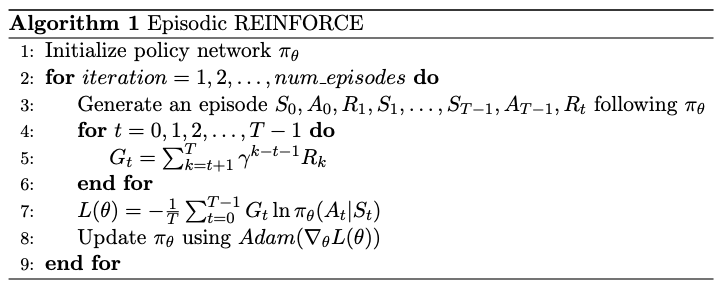

Let's implement this algorithm. First, we define our model to estimate the policy. In this tutorial, we use a simple neural network model as a policy estimator.


In [12]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x


Next, we prepare helper functions to generate an episode following the current policy model and evaluate the performance of the current policy.

In [13]:
def generate_episode(env, policy_net):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon of one episode
    state, _ = env.reset()
    for t in range(max_t):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
        action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        # action = np.argmax(probs.detach().numpy()) # greedy
        
        # compute the log_prob to use this in parameter update
        log_prob = torch.log(probs.squeeze(0)[action])
        
        # append values
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        # take a selected action
        state, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)

        if terminated | truncated:
            break
            
    return states, actions, rewards, log_probs


def evaluate_policy(env, policy_net):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_episode(env, policy_net)
    return np.sum(rewards)


Lastly, we implement a function to train the policy neural network. 

In [14]:
def train_REINRORCE(env, policy_net, policy_optimizer, gamma=0.99):
    """
    Trains the policy network on a single episode using REINFORCE
    """
    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_episode(env, policy_net)
    T = len(states)

    # Compute total discounted return at each time step
    Gs = []
    G = 0
    for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma*G
        Gs.insert(0,G)        

    # Compute objective function value L(theta)
    L_theta = []
    for log_prob, G in zip(log_probs, Gs):
        L_theta.append(-log_prob * G * 1/T) # to perform a gradient ascent, compute the negative objective value (minimizing this value-> maximizing the original objective value)
    L_theta = torch.stack(L_theta).sum() # accumulate all gradient to perform one update for one episode (not at every time step)

    # Update policy
    policy_optimizer.zero_grad() # reset all gradients to zero
    L_theta.backward() # compute the gradient
    policy_optimizer.step() # update the parameters (gradient descent)


Let's test whether REINFORCE can learn a good policy to solve the cart pole environment. In the below code, we train the policy network for 3,500 episodes using 5 different random seeds. To monitor learning progress, we freeze the network weights every 100 episodes and perform 20 episodes with the current policy, evaluating the test performance of the policy at each training phase. 

Note: The below code may take about 10 min to run.


In [16]:
# Define parameter values
env_name = 'CartPole-v1'
num_episodes = 3500
policy_lr = 5e-4 # policy network's learning rate
num_seeds = 5 # fit model with 5 different seeds and plot average performance of 5 seeds
l = num_episodes//100 # use to create x label for plot
returns = np.zeros((num_seeds, l)) # dim: (5 ,35)
gamma = 0.99 # discount factor

# Create the environment.
env = gym.make(env_name)
nA = env.action_space.n
nS = 4


  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0
The avg. test return for episode 0 is 20.4 with std. of 9.194563611178074.
Episode: 100
The avg. test return for episode 100 is 18.1 with std. of 6.640030120413611.
Episode: 200
The avg. test return for episode 200 is 22.05 with std. of 11.456330127924911.
Episode: 300
The avg. test return for episode 300 is 23.8 with std. of 11.948221624995078.
Episode: 400
The avg. test return for episode 400 is 26.3 with std. of 12.369721096289922.
Episode: 500
The avg. test return for episode 500 is 25.95 with std. of 14.602996267889683.
Episode: 600
The avg. test return for episode 600 is 32.35 with std. of 27.819552476630534.
Episode: 700
The avg. test return for episode 700 is 27.95 with std. of 13.904945163502084.
Episode: 800
The avg. test return for episode 800 is 40.35 with std. of 20.25160487467598.
Episode: 900
The avg. test return for episode 900 is 37.15 with std. of 18.461514022419724.
Episode: 1000
The avg. test return for episode 1000 is 52.55 with std. of 23.02927484746317

 20%|██        | 1/5 [01:05<04:22, 65.52s/it]

Episode: 0
The avg. test return for episode 0 is 16.4 with std. of 7.565712127751095.
Episode: 100
The avg. test return for episode 100 is 23.5 with std. of 11.244998888394788.
Episode: 200
The avg. test return for episode 200 is 31.5 with std. of 19.448650338776723.
Episode: 300
The avg. test return for episode 300 is 33.9 with std. of 22.80548179714693.
Episode: 400
The avg. test return for episode 400 is 33.8 with std. of 21.60925727552893.
Episode: 500
The avg. test return for episode 500 is 39.4 with std. of 22.88536650351049.
Episode: 600
The avg. test return for episode 600 is 51.15 with std. of 20.413904575068432.
Episode: 700
The avg. test return for episode 700 is 43.65 with std. of 18.963847183522653.
Episode: 800
The avg. test return for episode 800 is 37.8 with std. of 22.175662335091594.
Episode: 900
The avg. test return for episode 900 is 91.25 with std. of 49.90578623766988.
Episode: 1000
The avg. test return for episode 1000 is 205.35 with std. of 95.13793933021672.
Ep

 40%|████      | 2/5 [02:29<03:48, 76.11s/it]

Episode: 0
The avg. test return for episode 0 is 19.45 with std. of 5.962172422867356.
Episode: 100
The avg. test return for episode 100 is 26.3 with std. of 14.852945835759316.
Episode: 200
The avg. test return for episode 200 is 22.45 with std. of 8.285378687784887.
Episode: 300
The avg. test return for episode 300 is 26.0 with std. of 15.440207252495027.
Episode: 400
The avg. test return for episode 400 is 39.85 with std. of 21.033960635125286.
Episode: 500
The avg. test return for episode 500 is 53.25 with std. of 45.330866967222235.
Episode: 600
The avg. test return for episode 600 is 51.5 with std. of 36.63400060053502.
Episode: 700
The avg. test return for episode 700 is 78.1 with std. of 27.716240726332277.
Episode: 800
The avg. test return for episode 800 is 123.45 with std. of 65.51906211172441.
Episode: 900
The avg. test return for episode 900 is 103.1 with std. of 54.70914000420771.
Episode: 1000
The avg. test return for episode 1000 is 135.55 with std. of 71.07353586251355

 60%|██████    | 3/5 [03:36<02:24, 72.01s/it]

Episode: 0
The avg. test return for episode 0 is 20.4 with std. of 8.487638069569178.
Episode: 100
The avg. test return for episode 100 is 16.55 with std. of 5.181457323958193.
Episode: 200
The avg. test return for episode 200 is 24.3 with std. of 10.24743870437877.
Episode: 300
The avg. test return for episode 300 is 25.6 with std. of 16.057397049335236.
Episode: 400
The avg. test return for episode 400 is 22.4 with std. of 10.031948963187562.
Episode: 500
The avg. test return for episode 500 is 30.4 with std. of 19.181762171396038.
Episode: 600
The avg. test return for episode 600 is 30.35 with std. of 16.859048015828176.
Episode: 700
The avg. test return for episode 700 is 41.95 with std. of 20.51213055730682.
Episode: 800
The avg. test return for episode 800 is 35.6 with std. of 18.320480343047777.
Episode: 900
The avg. test return for episode 900 is 50.25 with std. of 24.768679819481697.
Episode: 1000
The avg. test return for episode 1000 is 67.8 with std. of 35.15053342411748.
Ep

 80%|████████  | 4/5 [05:01<01:17, 77.09s/it]

Episode: 0
The avg. test return for episode 0 is 18.7 with std. of 7.6164296097318465.
Episode: 100
The avg. test return for episode 100 is 23.5 with std. of 10.665364503850771.
Episode: 200
The avg. test return for episode 200 is 22.1 with std. of 10.783784122468328.
Episode: 300
The avg. test return for episode 300 is 20.85 with std. of 10.15517109653993.
Episode: 400
The avg. test return for episode 400 is 26.0 with std. of 14.007141035914502.
Episode: 500
The avg. test return for episode 500 is 28.7 with std. of 13.050287353158167.
Episode: 600
The avg. test return for episode 600 is 29.65 with std. of 15.60857136319657.
Episode: 700
The avg. test return for episode 700 is 50.7 with std. of 31.480311307228202.
Episode: 800
The avg. test return for episode 800 is 74.8 with std. of 46.08644052213189.
Episode: 900
The avg. test return for episode 900 is 56.5 with std. of 24.910841013502534.
Episode: 1000
The avg. test return for episode 1000 is 99.75 with std. of 38.475804085165.
Epis

100%|██████████| 5/5 [06:03<00:00, 72.76s/it]


Text(0.5, 1.0, 'REINFORCE Learning Curve')

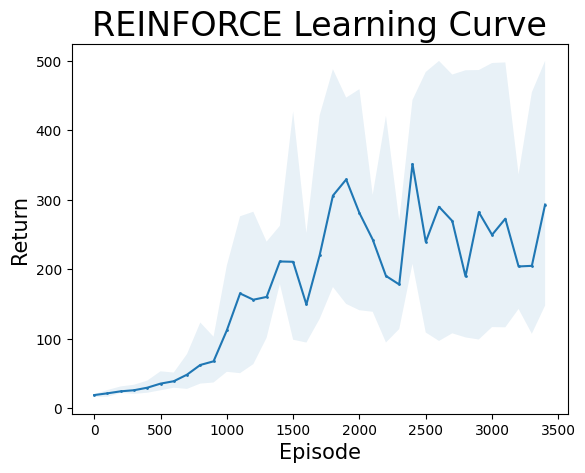

In [17]:
for i in tqdm.tqdm(range(num_seeds)):
    return_means = []

    # Define a policy network
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    
    for m in range(num_episodes):
        # Train a policy network with REINFORCE
        train_REINRORCE(env, policy_net, policy_net_optimizer, gamma=gamma)
        if m % 100 == 0:
            print(f"Episode: {m}")
            G = np.zeros(20)
            for k in range(20): # iterate over 20 test episodes
                g = evaluate_policy(env, policy_net)
                G[k] = g

            return_mean = G.mean()
            return_sd = G.std()
            print(f"The avg. test return for episode {m} is {return_mean} with std. of {return_sd}.")
            return_means.append(return_mean)
    returns[i] = np.array(return_means)

# Plot the performance over iterations
ks = np.arange(l)*100
avs = np.mean(returns, axis=0)
maxs = np.max(returns, axis=0)
mins = np.min(returns, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("REINFORCE Learning Curve", fontsize = 24)


In the above plot, the line shows the average return over 5 seeds and the shading shows the range between the min and max of returns for 5 seeds.

The learned policy does not achieve the maximum return (200) on average within 3500 episodes and there are large performance variances (i.e. the performance is unstable). But we can see that the policy gets better by having more episodes with REINFORCE.

## REINFORCE with baseline

One problem of REINFORCE is its high variance and thus produces slow learning. The REINFORCE algorithm estimates the gradient of the objective function using the expected returns by sampling trajectories. Because it relies on sampled trajectories, the gradient estimates can have high variance, leading to noisy updates. This high variance can result in large fluctuations in the policy parameters during training.

One idea to reduce this fluctuation is to include a comparison of the value to an arbitrary baseline $b(S_t)$:
\begin{align*}
\theta_{t+1} &= \theta_t + \alpha G_t \nabla \ln \pi(A_t|S_t,\theta) \quad (\text{REINFORCE})\\
\\
\theta_{t+1} &= \theta_t + \alpha (G_t-b(S_t)) \nabla \ln \pi(A_t|S_t,\theta) \quad (\text{REINFORCE with baseline})
\end{align*}

$(G_t-b(S_t))$ term is called advantage. The advantage represents how much better or worse the return by the current action is compared to the expected return at the state $S_t$. The baseline effectively reduces the scale of the return term in the policy gradient update. Since the advantage is multiplied by the gradient of the log probability of the action, a smaller advantage term results in smaller updates to the policy, leading to more stable policy gradient updates.

But is this a valid operation? In other words, even after subtracting the baseline, can the above equation be utilized as the estimate of the gradient of the objective function $J(\theta)$? We can show that this is a valid operation because adding the baseline term does not actually change the value of the equation as follows:

\begin{align*}
&\sum_s \mu(s) \sum_a (q_{\pi}(s,a)-b(s)) \nabla \pi(a|s, \theta) \\
&= \sum_s \mu(s) \sum_a (q_{\pi}(s,a)) \nabla \pi(a|s, \theta)-\sum_s \mu(s) \sum_a (b(s)) \nabla \pi(a|s, \theta) \\
&= \sum_s \mu(s) \sum_a (q_{\pi}(s,a)) \nabla \pi(a|s, \theta)-\sum_s \mu(s)  (b(s)) \nabla \sum_a \pi(a|s, \theta) \\
&= \sum_s \mu(s) \sum_a (q_{\pi}(s,a)) \nabla \pi(a|s, \theta)-\sum_s \mu(s)  (b(s)) \nabla 1 \quad (\text{because } \sum_a \pi(a|s, \theta)=1) \\
&= \sum_s \mu(s) \sum_a q_{\pi}(s,a) \nabla \pi(a|s, \theta) \quad (\text{because } \nabla 1=0) \\
&\propto \nabla J(\theta)
\end{align*}

The baseline can be any function, as long as it does not vary with $a$ because the gradient update equation remains valid/same even with adding $b(s)$. For example, we can use a constant value as a baseline for all states or some kind of regression model to estimate the average value at each state $s$.

When the baseline is uniformly zero, this update is the same as REINFORCE. Thus, this REINFORCE with baseline is a generalization of REINFORCE (or in other words, REINFORCE is a special case of REINFORCE with baseline).

Below is the pseudo-code of this update. In the below pseudo-code, the baseline state value is estimated by a parametric model with parameter $w$. 


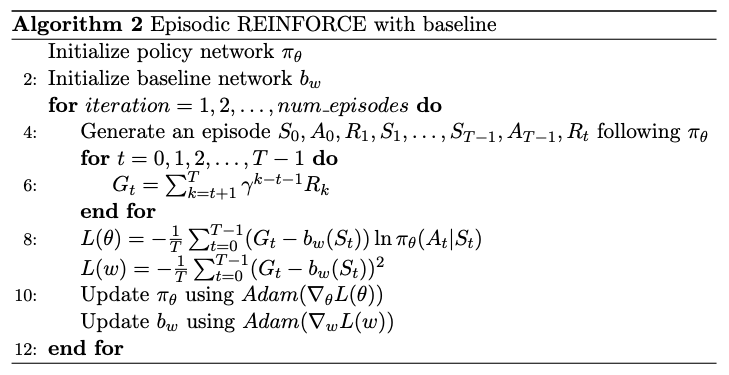

In the above pseudo-code, while we update the parameter for policy network $\theta$, we also update the parameter for the state value prediction model $w$ by using the advantage. The state value estimate parameter update uses the mean squared loss to minimize the prediction error between the predicted baseline value function and observed return. 
Note that in this algorithm, we have two different learning rates for each parameter, $\alpha^{\theta}$ and $\alpha^{w}$, which are hyperparameters of this algorithm.

The below code shows the implementation of the train function for REINFORCE + baseline.

In [18]:
def train_REINRORCE_baseline(env, policy_net, policy_optimizer, value_net, value_optimizer, gamma=0.99):
    """
    Trains the policy network on a single episode using REINFORCE with baseline
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_episode(env, policy_net)
    T = len(states)
    
    # Create tensors
    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)

    # Compute total discounted return at each time step
    Gs = []
    G = 0
    for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma*G
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        advantages = Gs - state_vals
        
    # Update policy network weights
    L_theta = torch.stack([-log_prob * advantage for log_prob, advantage in zip(log_probs, advantages)]).sum() / T
    policy_optimizer.zero_grad()
    L_theta.backward()
    policy_optimizer.step() 
    
    # Update value network weights
    loss_fn = nn.MSELoss()
    value_loss = loss_fn(state_vals, Gs)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step() 
    

Let's test whether REINFORCE with baseline can learn a good policy and reduce the variance in learning. 
As we did for REINFORCE, in the below code, we train the policy network for 3,500 episodes using 5 different random seeds. We freeze the weights of the network every 100 episodes and perform 20 episodes with the current policy to evaluate the test performance of the policy at each training phase. 

Note: The below code may take about 10 min to run.

  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0
The avg. test reward for episode 0 is 26.65 with std of 13.21845301084813.
Episode: 100
The avg. test reward for episode 100 is 23.3 with std of 12.86895489152091.
Episode: 200
The avg. test reward for episode 200 is 23.35 with std of 12.920042569589311.
Episode: 300
The avg. test reward for episode 300 is 25.4 with std of 13.514436725220923.
Episode: 400
The avg. test reward for episode 400 is 27.7 with std of 12.724386036269097.
Episode: 500
The avg. test reward for episode 500 is 38.4 with std of 23.631335129442007.
Episode: 600
The avg. test reward for episode 600 is 37.25 with std of 26.892145693491994.
Episode: 700
The avg. test reward for episode 700 is 47.8 with std of 26.314634711506066.
Episode: 800
The avg. test reward for episode 800 is 51.8 with std of 29.83052128273993.
Episode: 900
The avg. test reward for episode 900 is 36.15 with std of 19.034902153675496.
Episode: 1000
The avg. test reward for episode 1000 is 124.75 with std of 47.51723371577937.
Episode: 1

 20%|██        | 1/5 [02:16<09:04, 136.03s/it]

Episode: 0
The avg. test reward for episode 0 is 23.15 with std of 16.072569800750593.
Episode: 100
The avg. test reward for episode 100 is 24.05 with std of 11.629595865721216.
Episode: 200
The avg. test reward for episode 200 is 29.65 with std of 25.395422815932797.
Episode: 300
The avg. test reward for episode 300 is 49.8 with std of 20.38283591652545.
Episode: 400
The avg. test reward for episode 400 is 187.4 with std of 96.03353580911202.
Episode: 500
The avg. test reward for episode 500 is 361.25 with std of 145.9951625910941.
Episode: 600
The avg. test reward for episode 600 is 455.3 with std of 86.77908734251588.
Episode: 700
The avg. test reward for episode 700 is 482.85 with std of 51.93965248247238.
Episode: 800
The avg. test reward for episode 800 is 489.5 with std of 31.80958974900494.
Episode: 900
The avg. test reward for episode 900 is 493.35 with std of 28.758085819469972.
Episode: 1000
The avg. test reward for episode 1000 is 500.0 with std of 0.0.
Episode: 1100
The av

 40%|████      | 2/5 [05:14<08:02, 160.83s/it]

Episode: 0
The avg. test reward for episode 0 is 20.8 with std of 8.207313811473277.
Episode: 100
The avg. test reward for episode 100 is 19.3 with std of 12.53435279541788.
Episode: 200
The avg. test reward for episode 200 is 39.25 with std of 19.49839737004044.
Episode: 300
The avg. test reward for episode 300 is 48.65 with std of 21.216208426578014.
Episode: 400
The avg. test reward for episode 400 is 140.25 with std of 59.13786857843289.
Episode: 500
The avg. test reward for episode 500 is 254.05 with std of 99.38887010123418.
Episode: 600
The avg. test reward for episode 600 is 399.6 with std of 132.1088187820934.
Episode: 700
The avg. test reward for episode 700 is 429.8 with std of 98.96544851613618.
Episode: 800
The avg. test reward for episode 800 is 448.8 with std of 65.86243238751511.
Episode: 900
The avg. test reward for episode 900 is 476.7 with std of 62.106440889814316.
Episode: 1000
The avg. test reward for episode 1000 is 475.35 with std of 70.09013839335745.
Episode: 

 60%|██████    | 3/5 [08:09<05:34, 167.36s/it]

Episode: 0
The avg. test reward for episode 0 is 21.75 with std of 11.321991874224253.
Episode: 100
The avg. test reward for episode 100 is 22.2 with std of 13.059862173851606.
Episode: 200
The avg. test reward for episode 200 is 25.25 with std of 10.949315047070296.
Episode: 300
The avg. test reward for episode 300 is 22.85 with std of 14.318781372728617.
Episode: 400
The avg. test reward for episode 400 is 27.3 with std of 19.165333286953295.
Episode: 500
The avg. test reward for episode 500 is 27.65 with std of 12.787787142426167.
Episode: 600
The avg. test reward for episode 600 is 22.45 with std of 8.783364958829845.
Episode: 700
The avg. test reward for episode 700 is 29.15 with std of 13.635523458965555.
Episode: 800
The avg. test reward for episode 800 is 38.1 with std of 15.322858741109636.
Episode: 900
The avg. test reward for episode 900 is 52.55 with std of 31.767082018970523.
Episode: 1000
The avg. test reward for episode 1000 is 79.25 with std of 42.68591688133218.
Episod

 80%|████████  | 4/5 [10:23<02:34, 154.38s/it]

Episode: 0
The avg. test reward for episode 0 is 13.5 with std of 6.119640512317697.
Episode: 100
The avg. test reward for episode 100 is 16.85 with std of 7.531766061157238.
Episode: 200
The avg. test reward for episode 200 is 22.75 with std of 12.790132915650252.
Episode: 300
The avg. test reward for episode 300 is 26.5 with std of 12.944110629935144.
Episode: 400
The avg. test reward for episode 400 is 53.95 with std of 26.428157332663208.
Episode: 500
The avg. test reward for episode 500 is 128.8 with std of 52.56671950959086.
Episode: 600
The avg. test reward for episode 600 is 326.35 with std of 148.78113959773262.
Episode: 700
The avg. test reward for episode 700 is 463.3 with std of 81.4285576441091.
Episode: 800
The avg. test reward for episode 800 is 499.1 with std of 3.9230090491866054.
Episode: 900
The avg. test reward for episode 900 is 470.6 with std of 89.05807094250356.
Episode: 1000
The avg. test reward for episode 1000 is 489.3 with std of 42.276589266401324.
Episode:

100%|██████████| 5/5 [13:15<00:00, 159.05s/it]


Text(0.5, 1.0, 'REINFORCE with baseline Learning Curve')

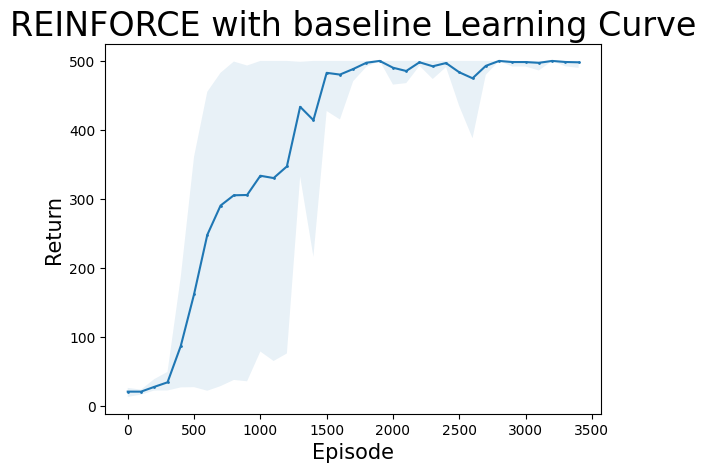

In [19]:
policy_lr = 5e-4
baseline_lr = 5e-4
returns = np.zeros((num_seeds, l)) # dim: (5 ,35)

for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_episodes):
        # Train networks with REINFORCE with baseline
        train_REINRORCE_baseline(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, gamma=gamma)
        if m % 100 == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

    
# Plot the performance over iterations
ks = np.arange(l)*100
avs = np.mean(returns, axis=0)
maxs = np.max(returns, axis=0)
mins = np.min(returns, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("REINFORCE with baseline Learning Curve", fontsize = 24)


REINFORCE with baseline converges to the best performance around 1000th episodes (although the result could slightly vary on each run) and achieves a much smaller variance compared to REINFORCE as we expected. The use of a baseline offered a significant performance improvement in this case.

In [44]:
def train_REINRORCE_baseline_entropy(env, policy_net, policy_optimizer, value_net, value_optimizer, gamma=0.99, entropy_coef=0.01):
    """
    Trains the policy network on a single episode using REINFORCE with baseline
    """


    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_episode(env, policy_net)
    T = len(states)
    
    # Create tensors
    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    
    

    # Compute total discounted return at each time step
    Gs = []
    G = 0
    for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma*G
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        advantages = Gs - state_vals
    

    # Calculate probability of each action under the updated policy
    probs = policy_net.forward(states).to(device)
        
    # Update policy network weights
    # Caluculate entropy
    entropy = torch.distributions.Categorical(probs).entropy()
    entropy = torch.tensor([[e] for e in entropy])

    # Update policy network weights
    L_theta = torch.stack([-log_prob * advantage - entropy_coef * ent for log_prob, advantage, ent in zip(log_probs, advantages, entropy)]).sum() / T
    policy_optimizer.zero_grad()
    L_theta.backward(retain_graph=True)
    policy_optimizer.step() 
    
    # Update value network weights
    loss_fn = nn.MSELoss()
    # value_loss = loss_fn(state_vals, Gs)
    value_loss = loss_fn(state_vals, Gs)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step() 
    

  0%|          | 0/5 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Episode: 0
The avg. test reward for episode 0 is 26.15 with std of 14.164303724504075.
Episode: 100
The avg. test reward for episode 100 is 19.65 with std of 7.108269831681969.
Episode: 200
The avg. test reward for episode 200 is 22.05 with std of 14.55154630958511.
Episode: 300
The avg. test reward for episode 300 is 33.25 with std of 15.97771886096385.
Episode: 400
The avg. test reward for episode 400 is 49.25 with std of 27.46793585255361.
Episode: 500
The avg. test reward for episode 500 is 121.15 with std of 47.84796233905892.
Episode: 600
The avg. test reward for episode 600 is 229.45 with std of 75.75320125248832.
Episode: 700
The avg. test reward for episode 700 is 420.5 with std of 119.18871590884768.
Episode: 800
The avg. test reward for episode 800 is 439.7 with std of 114.29133825448017.
Episode: 900
The avg. test reward for episode 900 is 500.0 with std of 0.0.
Episode: 1000
The avg. test reward for episode 1000 is 464.4 with std of 92.70350586682254.
Episode: 1100
The avg

 20%|██        | 1/5 [03:11<12:44, 191.25s/it]

Episode: 0
The avg. test reward for episode 0 is 24.85 with std of 11.697328754891007.
Episode: 100
The avg. test reward for episode 100 is 20.85 with std of 8.290205063808736.
Episode: 200
The avg. test reward for episode 200 is 33.7 with std of 22.34972035619238.
Episode: 300
The avg. test reward for episode 300 is 36.45 with std of 17.79740149572403.
Episode: 400
The avg. test reward for episode 400 is 106.35 with std of 40.10520539780341.
Episode: 500
The avg. test reward for episode 500 is 158.7 with std of 87.40486256496258.
Episode: 600
The avg. test reward for episode 600 is 467.95 with std of 71.93988810110841.
Episode: 700
The avg. test reward for episode 700 is 478.9 with std of 91.9727677087082.
Episode: 800
The avg. test reward for episode 800 is 486.0 with std of 54.53439281774392.
Episode: 900
The avg. test reward for episode 900 is 448.75 with std of 90.93727233648478.
Episode: 1000
The avg. test reward for episode 1000 is 462.25 with std of 86.10277289379245.
Episode: 

 40%|████      | 2/5 [06:24<09:37, 192.62s/it]

Episode: 0
The avg. test reward for episode 0 is 20.75 with std of 11.19765600471813.
Episode: 100
The avg. test reward for episode 100 is 22.55 with std of 15.187083327617584.
Episode: 200
The avg. test reward for episode 200 is 33.7 with std of 22.629847546989797.
Episode: 300
The avg. test reward for episode 300 is 83.9 with std of 44.6653109246986.
Episode: 400
The avg. test reward for episode 400 is 179.05 with std of 72.48894743338464.
Episode: 500
The avg. test reward for episode 500 is 391.2 with std of 119.9223081832567.
Episode: 600
The avg. test reward for episode 600 is 436.25 with std of 97.98973160489827.
Episode: 700
The avg. test reward for episode 700 is 493.4 with std of 28.768733027368448.
Episode: 800
The avg. test reward for episode 800 is 500.0 with std of 0.0.
Episode: 900
The avg. test reward for episode 900 is 477.8 with std of 69.88891185302572.
Episode: 1000
The avg. test reward for episode 1000 is 485.2 with std of 55.82347176591581.
Episode: 1100
The avg. t

 60%|██████    | 3/5 [09:42<06:29, 194.76s/it]

Episode: 0
The avg. test reward for episode 0 is 19.25 with std of 7.693341276714559.
Episode: 100
The avg. test reward for episode 100 is 24.25 with std of 15.148844840449057.
Episode: 200
The avg. test reward for episode 200 is 38.2 with std of 24.324062160749385.
Episode: 300
The avg. test reward for episode 300 is 39.2 with std of 20.16829194552677.
Episode: 400
The avg. test reward for episode 400 is 65.3 with std of 24.615239182262684.
Episode: 500
The avg. test reward for episode 500 is 132.45 with std of 57.2507423532656.
Episode: 600
The avg. test reward for episode 600 is 291.5 with std of 120.19463382364455.
Episode: 700
The avg. test reward for episode 700 is 422.55 with std of 107.18464209018008.
Episode: 800
The avg. test reward for episode 800 is 467.55 with std of 96.8449663121424.
Episode: 900
The avg. test reward for episode 900 is 496.2 with std of 16.56381598545456.
Episode: 1000
The avg. test reward for episode 1000 is 478.35 with std of 84.11377711171934.
Episode:

 80%|████████  | 4/5 [12:50<03:12, 192.29s/it]

Episode: 0
The avg. test reward for episode 0 is 18.5 with std of 8.680437776978762.
Episode: 100
The avg. test reward for episode 100 is 27.2 with std of 9.325234581499814.
Episode: 200
The avg. test reward for episode 200 is 35.8 with std of 26.07987730032486.
Episode: 300
The avg. test reward for episode 300 is 54.35 with std of 21.863840010391588.
Episode: 400
The avg. test reward for episode 400 is 118.25 with std of 50.26417710457419.
Episode: 500
The avg. test reward for episode 500 is 446.5 with std of 101.77450564851691.
Episode: 600
The avg. test reward for episode 600 is 471.75 with std of 84.3474214187962.
Episode: 700
The avg. test reward for episode 700 is 459.25 with std of 70.38527900065468.
Episode: 800
The avg. test reward for episode 800 is 484.6 with std of 60.59735967845464.
Episode: 900
The avg. test reward for episode 900 is 486.5 with std of 58.84513573779909.
Episode: 1000
The avg. test reward for episode 1000 is 433.5 with std of 95.45182030742001.
Episode: 11

100%|██████████| 5/5 [16:10<00:00, 194.09s/it]


Text(0.5, 1.0, 'REINFORCE with baseline&entropy Learning Curve')

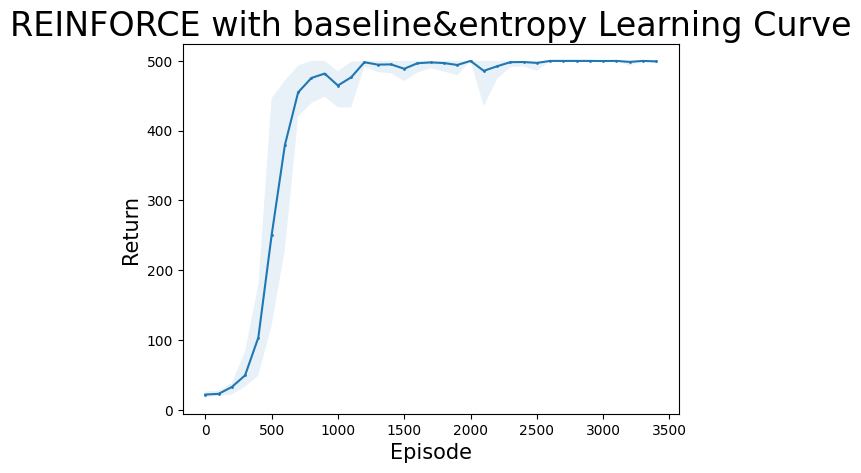

In [45]:
policy_lr = 5e-4
baseline_lr = 5e-4
returns = np.zeros((num_seeds, l)) # dim: (5 ,35)

for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_episodes):
        # Train networks with REINFORCE with baseline
        train_REINRORCE_baseline_entropy(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, gamma=gamma)
        if m % 100 == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)

    
# Plot the performance over iterations
ks = np.arange(l)*100
avs = np.mean(returns, axis=0)
maxs = np.max(returns, axis=0)
mins = np.min(returns, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("REINFORCE with baseline&entropy Learning Curve", fontsize = 24)


## Actor Critic

One disadvantage of REINFORCE and REINFORCE+baseline is that it has to wait until the end of the episode to perform the update because the update depends on the return $G$. Another disadvantage is while introducing baseline relieves the large variance, the variance often remains high because the algorithm relies on the noisy sampled return $G$. 
These disadvantages are similar to Monte Carlo Methods for solving finite Markov Decision Process (MDP). To overcome this limitation, in the MDP setup, we use TD-learning, which uses value estimate to perform the online update of the estimate (i.e. bootstrapping). This helps reduce the variance too by removing the dependency on the sampled return $G$.

Can we use a similar strategy in the case of policy gradient? Yes, we can. Let's think about how we can replace return term $G$ in the REINFORCE with baseline update equation with a value estimate. The simplest thing we can do is to estimate the state value as the sum of the immediate reward and the value of the next state, i.e. $R_{t+1}+\gamma \widehat{v}(S_{t+1}, w)$ as we do with TD(0) method (You can learn more about TD(0) in [this notebook](https://www.kaggle.com/code/minaiyuki/solving-mdp-using-td-learning-sarsa-q-learning)). Then, we can write down the policy parameter update equation with advantage as follows:

$$\theta_{t+1}=\theta_t + \alpha (R_{t+1}+\gamma \widehat{v}(S_{t+1}, w)-\widehat{v}(S_t, w)) \nabla \ln \pi(A_t|S_t,\theta)$$

This algorithm using the sum of immediate reward and the value estimate of the next state is called a one-step acrot-critic method. 

In general. methods that learn approximations to both policy and value functions are called actor-critic methods, where the actor refers to the learned policy, and the critic refers to the learned value function.

Below is the pseudo-code of the N-step Actor-Critic algorithm, which is a generalization of the one-step actor critic method and uses the sum of the N-step of immediate return and state value estimate of the next state.


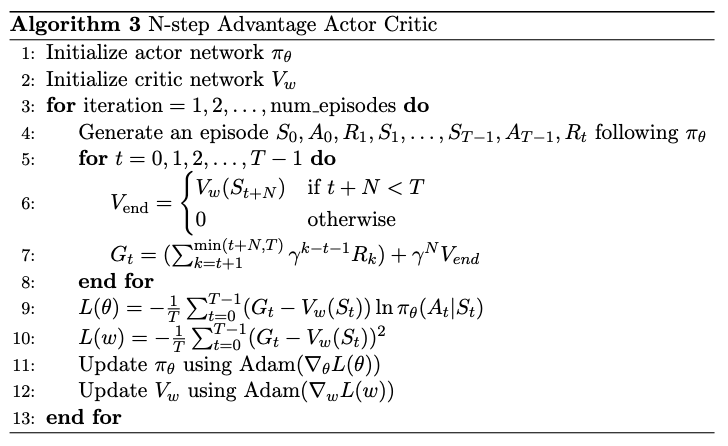

We can see that the return term ($G_t$) uses the value estimate while we did not have this term in REINFORCE+baseline.
$$ G_t = \sum^T_{k=t+1}\gamma^{k-t-1}R_k  \quad (\text{REINFORCE with baseline})$$
$$ G_t = (\sum^{\min(t+N, T)}_{k=t+1}\gamma^{k-t-1}R_k)+\gamma^N V_{end}  \quad (\text{Actor Critic})$$

Let's see the implementation of this N-step Actor-Critic method.

Note: The below code may take about 10 min to run.

In [46]:
# Implementation
def train_actor_critic(env, policy_net, policy_optimizer, value_net, value_optimizer, gamma=0.99):
    """
    Trains the policy network on a single episode using Actor Critic
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_episode(env, policy_net)
    T = len(states)
    
    # Create tensors
    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device).view(-1,1)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    # log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Initialize Gs as an empty list
    Gs = []

    # Loop through each time step
    for t in range(T):
        end_time = t + n if t + n < T else T  # Determine the end of the trajectory

        # Calculate the discounted return G for time step t
        G = 0
        for t_inner in range(t, end_time):
            G += gamma**(t_inner - t) * rewards[t_inner]
            
        # If end_time is within the trajectory, add the value function estimate
        if end_time < T:
            V_end = value_net.forward(states[end_time]).item()
            G += gamma**n * V_end

        # Append the calculated G to the list
        Gs.append(G)
        
    Gs = torch.tensor(Gs).view(-1,1)

    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        advantages = Gs - state_vals
        
    # Update policy network weights
    policy_loss = torch.stack([-log_prob * advantage for log_prob, advantage in zip(log_probs, advantages)]).sum() / T
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step() 
    
    # Update value network weights
    loss_fn = nn.MSELoss()
    value_loss = loss_fn(state_vals, Gs)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step() 
    

  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0
The avg. test reward for episode 0 is 20.45 with std. of 7.8833685693363345.
Episode: 100
The avg. test reward for episode 100 is 22.8 with std. of 14.158389738949836.
Episode: 200
The avg. test reward for episode 200 is 23.95 with std. of 13.347190715652488.
Episode: 300
The avg. test reward for episode 300 is 29.05 with std. of 13.328447021314973.
Episode: 400
The avg. test reward for episode 400 is 24.0 with std. of 9.528903399657276.
Episode: 500
The avg. test reward for episode 500 is 38.85 with std. of 18.775715698742353.
Episode: 600
The avg. test reward for episode 600 is 45.25 with std. of 18.400747267434546.
Episode: 700
The avg. test reward for episode 700 is 41.7 with std. of 17.782294565100422.
Episode: 800
The avg. test reward for episode 800 is 40.8 with std. of 15.008664164408502.
Episode: 900
The avg. test reward for episode 900 is 40.6 with std. of 18.717371610351705.
Episode: 1000
The avg. test reward for episode 1000 is 56.5 with std. of 23.07271115408850

 20%|██        | 1/5 [02:06<08:26, 126.70s/it]

Episode: 0
The avg. test reward for episode 0 is 21.55 with std. of 14.364800729561132.
Episode: 100
The avg. test reward for episode 100 is 21.35 with std. of 9.870536966143229.
Episode: 200
The avg. test reward for episode 200 is 17.8 with std. of 7.166589146867567.
Episode: 300
The avg. test reward for episode 300 is 17.05 with std. of 6.111260099193946.
Episode: 400
The avg. test reward for episode 400 is 19.05 with std. of 5.572028355993892.
Episode: 500
The avg. test reward for episode 500 is 29.15 with std. of 17.782786620774598.
Episode: 600
The avg. test reward for episode 600 is 43.35 with std. of 27.081866626951694.
Episode: 700
The avg. test reward for episode 700 is 66.95 with std. of 45.433990579741064.
Episode: 800
The avg. test reward for episode 800 is 138.35 with std. of 62.788752973761156.
Episode: 900
The avg. test reward for episode 900 is 136.45 with std. of 35.943671209268544.
Episode: 1000
The avg. test reward for episode 1000 is 165.25 with std. of 46.886965139

 40%|████      | 2/5 [09:53<16:19, 326.55s/it]

Episode: 0
The avg. test reward for episode 0 is 21.55 with std. of 11.042984198123259.
Episode: 100
The avg. test reward for episode 100 is 27.7 with std. of 12.63368513142543.
Episode: 200
The avg. test reward for episode 200 is 29.2 with std. of 14.517575555167605.
Episode: 300
The avg. test reward for episode 300 is 49.75 with std. of 37.38030898748698.
Episode: 400
The avg. test reward for episode 400 is 66.4 with std. of 34.49695638748439.
Episode: 500
The avg. test reward for episode 500 is 125.6 with std. of 51.94554841369951.
Episode: 600
The avg. test reward for episode 600 is 134.9 with std. of 37.48586400231426.
Episode: 700
The avg. test reward for episode 700 is 275.9 with std. of 105.2297011304318.
Episode: 800
The avg. test reward for episode 800 is 320.7 with std. of 99.3901906628617.
Episode: 900
The avg. test reward for episode 900 is 362.35 with std. of 84.35358617154341.
Episode: 1000
The avg. test reward for episode 1000 is 180.55 with std. of 47.53259408027295.
E

 60%|██████    | 3/5 [18:34<13:50, 415.30s/it]

Episode: 0
The avg. test reward for episode 0 is 24.9 with std. of 14.01392164955977.
Episode: 100
The avg. test reward for episode 100 is 25.65 with std. of 14.402343559296174.
Episode: 200
The avg. test reward for episode 200 is 24.25 with std. of 8.50220559619679.
Episode: 300
The avg. test reward for episode 300 is 34.45 with std. of 18.230400434439172.
Episode: 400
The avg. test reward for episode 400 is 40.55 with std. of 20.60212367694166.
Episode: 500
The avg. test reward for episode 500 is 71.45 with std. of 29.853768606325065.
Episode: 600
The avg. test reward for episode 600 is 87.35 with std. of 34.26554391805272.
Episode: 700
The avg. test reward for episode 700 is 113.8 with std. of 36.78668237283704.
Episode: 800
The avg. test reward for episode 800 is 225.4 with std. of 54.65747890270828.
Episode: 900
The avg. test reward for episode 900 is 147.1 with std. of 19.364658530425988.
Episode: 1000
The avg. test reward for episode 1000 is 216.0 with std. of 72.34638899074369.

 80%|████████  | 4/5 [26:56<07:29, 449.58s/it]

Episode: 0
The avg. test reward for episode 0 is 23.75 with std. of 12.397076268217438.
Episode: 100
The avg. test reward for episode 100 is 30.4 with std. of 13.005383500689243.
Episode: 200
The avg. test reward for episode 200 is 28.35 with std. of 12.44296990272017.
Episode: 300
The avg. test reward for episode 300 is 24.9 with std. of 9.792343948207703.
Episode: 400
The avg. test reward for episode 400 is 45.9 with std. of 32.98014554243204.
Episode: 500
The avg. test reward for episode 500 is 114.35 with std. of 92.76490446284087.
Episode: 600
The avg. test reward for episode 600 is 167.25 with std. of 54.31470795281882.
Episode: 700
The avg. test reward for episode 700 is 231.95 with std. of 115.3488079695668.
Episode: 800
The avg. test reward for episode 800 is 113.7 with std. of 39.67253457998367.
Episode: 900
The avg. test reward for episode 900 is 365.7 with std. of 131.84236800057863.
Episode: 1000
The avg. test reward for episode 1000 is 252.2 with std. of 58.88684063523870

100%|██████████| 5/5 [35:13<00:00, 422.63s/it]


Text(0.5, 1.0, 'Actor Critic Learning Curve')

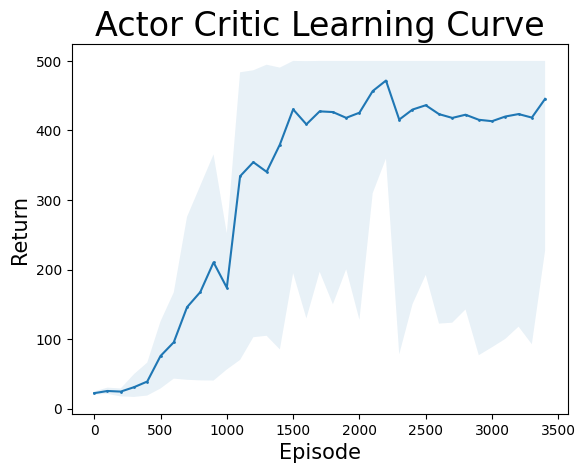

In [47]:
policy_lr = 5e-4
critic_lr = 1e-4
n = 100 # number of time step to use immediate reward
returns = np.zeros((num_seeds, l)) # dim: (5 ,35)

for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=critic_lr)
    
    for m in range(num_episodes):
        train_actor_critic(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, gamma=gamma)
        if m % 100 == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std. of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)


# Plot the performance over iterations
ks = np.arange(l)*100
avs = np.mean(returns, axis=0)
maxs = np.max(returns, axis=0)
mins = np.min(returns, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("Actor Critic Learning Curve", fontsize = 24)


In the CartPole-v0 environment with the specified hyperparameters, the actor-critic method does not outperform REINFORCE with a baseline. It takes a longer time to converge to the best score, and the variance around the performance is greater compared to REINFORCE with a baseline. This could be attributed to suboptimal hyperparameters (such as learning rate, the number of immediate reward steps, and discount rate) used in this code. However, this outcome also highlights the inherent challenges of actor-critic methods, which involve training two networks, as opposed to the simplicity of tuning a single value network in REINFORCE with a baseline.

Another possible explanation is that the value function in this environment is relatively straightforward, and the use of bootstrapping in actor-critic does not have a significant advantage over REINFORCE with a baseline. In environments with relatively simple state and action spaces, where complexity is not a significant factor, REINFORCE with a baseline might be more effective. Actor-critic methods, with their additional complexity of maintaining a value function, might introduce unnecessary complications in such scenarios.

## Summary

In this notebook, we learned three fundamental policy gradient methods: REINFORCE, REINFORCE with baseline, and Actor Critic. The Policy Gradient Theorem provides the foundation of the policy gradient methods by offering a way to estimate the gradient of the objective function. REINFORCE uses the sampled return to learn the optimal policy. REINFORCE with baseline introduces a baseline estimate of the value at each state to stabilize and accelerate the learning. Actor Critic uses bootstrapping to further improve the learning performance (although this was not very effective for this notebook case).
Depending on the problem setting, it would be important to carefully consider which approach would be more effective, whether using methods based on value function estimates or using policy gradient methods.

## Ref

- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.
